## CREDIT ANALAYZER - DECISION TREE WITH CLAUDE API INTEGRATION

### 01: Data Exploration Workbook

=================================================================
#### SECTION 1: IMPORT PACKAGES, DATA LOADING, INITIAL EXPLORATION
=================================================================

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn import tree

In [2]:
df = pd.read_csv("../data/accepted_2007_to_2018Q4.csv.gz", compression="gzip", low_memory=False)

In [3]:
print(f"Dataset shape: {df.shape}")
print(f"\nAll columns ({len(df.columns)} total):")
for i, col in enumerate(df.columns, 1):
    print(f"{i:3d}. {col}")

Dataset shape: (2260701, 151)

All columns (151 total):
  1. id
  2. member_id
  3. loan_amnt
  4. funded_amnt
  5. funded_amnt_inv
  6. term
  7. int_rate
  8. installment
  9. grade
 10. sub_grade
 11. emp_title
 12. emp_length
 13. home_ownership
 14. annual_inc
 15. verification_status
 16. issue_d
 17. loan_status
 18. pymnt_plan
 19. url
 20. desc
 21. purpose
 22. title
 23. zip_code
 24. addr_state
 25. dti
 26. delinq_2yrs
 27. earliest_cr_line
 28. fico_range_low
 29. fico_range_high
 30. inq_last_6mths
 31. mths_since_last_delinq
 32. mths_since_last_record
 33. open_acc
 34. pub_rec
 35. revol_bal
 36. revol_util
 37. total_acc
 38. initial_list_status
 39. out_prncp
 40. out_prncp_inv
 41. total_pymnt
 42. total_pymnt_inv
 43. total_rec_prncp
 44. total_rec_int
 45. total_rec_late_fee
 46. recoveries
 47. collection_recovery_fee
 48. last_pymnt_d
 49. last_pymnt_amnt
 50. next_pymnt_d
 51. last_credit_pull_d
 52. last_fico_range_high
 53. last_fico_range_low
 54. collectio

In [4]:
#create a copy of the dataframe for exploration and modeling
df_model = df.copy()

=================================================================
#### SECTION 2: TARGET VARIABLE ENGINEERING
=================================================================

In [5]:
# Check the target variable
print("\n" + "="*50)
print("Loan Status Distribution:")
print(df_model['loan_status'].value_counts())


Loan Status Distribution:
loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64


In [6]:
# convert "Does not meet the credit policy. Status:Fully Paid" to "Fully Paid" and similar for "Charged Off"
df_model['loan_status'] = df_model['loan_status'].replace({'Does not meet the credit policy. Status:Fully Paid': 'Fully Paid',
                                         'Does not meet the credit policy. Status:Charged Off': 'Charged Off'})

In [7]:
#convert Default to Charged Off
df_model['loan_status'] = df_model['loan_status'].replace({'Default': 'Charged Off'})

In [8]:
# check unique values again
df_model['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', nan], dtype=object)

In [9]:
#check null or NaN values in target variable
df_model[df_model['loan_status'].isna()].shape

(33, 151)

In [10]:
#remove current loans from dataset and keep only fully paid and charged off loans
df_model = df_model[df_model['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [11]:
# Create binary default target
def create_default_flag(status):
    if 'Fully Paid' in status:
        return 0  # Good loan
    elif 'Charged Off' in status:
        return 1  # Bad loan
    else:
        return None  # Can't determine yet (Current, Late, etc.)

In [12]:
default_flag = []

for i in df_model['loan_status']:
    default_flag.append(create_default_flag(i))

In [13]:
df_model['default_flag'] = default_flag

# Drop loans where outcome is unknown
df_model = df_model[df_model['default_flag'].notna()].copy()


Target distribution:
default_flag
0    1078739
1     269360
Name: count, dtype: int64

Default rate: 19.98%


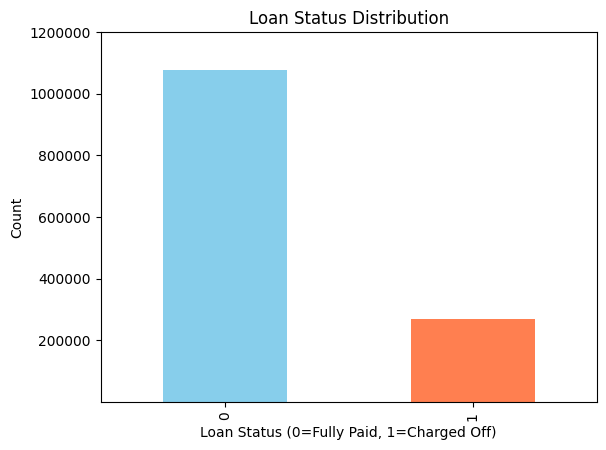

In [14]:
#Visualize target distribution
print("\nTarget distribution:")
print(df_model['default_flag'].value_counts())
print(f"\nDefault rate: {df_model['default_flag'].mean():.2%}")

df_model['default_flag'].value_counts().plot(kind='bar', color = ['skyblue', 'coral'],
                                             title='Loan Status Distribution')
plt.xlabel('Loan Status (0=Fully Paid, 1=Charged Off)')
plt.ylabel('Count')
plt.ticklabel_format(style='plain', axis='y')
new_tick_positions = [200000, 400000, 600000, 800000, 1000000, 1200000]
plt.yticks(new_tick_positions)
plt.show()

=================================================================
#### SECTION 3: FEATURE SELECTION & ENGINEERING
=================================================================

In [15]:
print(len(df_model.columns)) #reduced columns to 94

152


In [16]:
#intuitive drop list based on domain knowledge and relevance to the target variable
application_features = [
    # Loan details
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'purpose',
    
    # Borrower profile
    'annual_inc', 'emp_length', 'home_ownership', 'verification_status',
    
    # Credit metrics
    'dti', 'fico_range_low', 'fico_range_high', 'delinq_2yrs', 'inq_last_6mths',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
    'pub_rec_bankruptcies', 'tot_cur_bal', 'total_rev_hi_lim', 
    
    #targets
    'funded_amnt', 'default_flag'
]

df_model = df_model[application_features].copy()

In [17]:
print(len(df_model.columns))

26


In [18]:
#based on signficant missing values and relevance to the target, we will drop the following columns:

missing_fractions = df_model.isnull().mean().sort_values(ascending=False)

#lets drop the columns with more than 50% missing values
cols_to_drop = missing_fractions[missing_fractions > 0.3].index.tolist()
print(f"\nDropping {len(cols_to_drop)} columns with >30% missing values:")
for col in cols_to_drop:
    print(f"- {col} ({missing_fractions[col]:.2%} missing)")
df_model = df_model.drop(columns=cols_to_drop)


Dropping 0 columns with >30% missing values:


In [19]:


#Convert term to integer after nan removal
df_model['term'] = df_model['term'].replace(" ", "").str[:3].astype(int)


In [20]:
df_model['emp_length'] = df_model['emp_length'].replace({"10+ years": 10, "9 years": 9, "8 years": 8, "7 years": 7, "6 years": 6, "5 years": 5, "4 years": 4, "3 years": 3, "2 years": 2, "1 year": 1, "< 1 year": 0})

/var/folders/b6/z2j2f1js49s1rw1gfk04vyp40000gn/T/ipykernel_8341/395925736.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model['emp_length'] = df_model['emp_length'].replace({"10+ years": 10, "9 years": 9, "8 years": 8, "7 years": 7, "6 years": 6, "5 years": 5, "4 years": 4, "3 years": 3, "2 years": 2, "1 year": 1, "< 1 year": 0})


In [21]:
df_model['emp_length'] = df_model['emp_length'].fillna(df_model['emp_length'].median())

In [22]:
# 1. Fix grade encoding BEFORE train/test split
grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
sub_grade_map = {
    'A1':1,'A2':2,'A3':3,'A4':4,'A5':5,
    'B1':6,'B2':7,'B3':8,'B4':9,'B5':10,
    'C1':11,'C2':12,'C3':13,'C4':14,'C5':15,
    'D1':16,'D2':17,'D3':18,'D4':19,'D5':20,
    'E1':21,'E2':22,'E3':23,'E4':24,'E5':25,
    'F1':26,'F2':27,'F3':28,'F4':29,'F5':30,
    'G1':31,'G2':32,'G3':33,'G4':34,'G5':35
}

df_model['grade'] = df_model['grade'].map(grade_map)
df_model['sub_grade'] = df_model['sub_grade'].map(sub_grade_map)

df_model['purpose'] = df_model['purpose'].astype('category').cat.codes
df_model['home_ownership'] = df_model['home_ownership'].astype('category').cat.codes
df_model['verification_status'] = df_model['verification_status'].astype('category').cat.codes

In [23]:
# AND fix remaining NaNs
numeric_cols = df_model.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    df_model[col] = df_model[col].fillna(df_model[col].median())

print(f"Remaining NaNs: {df_model.isnull().sum().sum()}")

Remaining NaNs: 0


In [24]:
print(len(df_model.columns))

26


In [25]:
#targets = ['default_flag', 'funded_amnt'] # Classification and regression targets

In [26]:
df_model.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'purpose', 'annual_inc', 'emp_length', 'home_ownership',
       'verification_status', 'dti', 'fico_range_low', 'fico_range_high',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'pub_rec_bankruptcies', 'tot_cur_bal',
       'total_rev_hi_lim', 'funded_amnt', 'default_flag'],
      dtype='object')

=================================================================
#### SECTION 4: BASELINE MODELS (A, B, C)
=================================================================

In [27]:
#set the seed for reproducibility across all random operations
seed = 42
np.random.seed(seed)
random.seed(42)

##### MODEL A: With Grade and Sub-Grade

In [28]:
feature_cols = [col for col in df_model.columns 
                if col not in ['loan_status', 'default_flag', 'funded_amnt']]

X = df_model[feature_cols]
y = df_model['default_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [29]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [30]:
# Constrained tree this time
clf = DecisionTreeClassifier(
    max_depth=8,
    min_samples_split=500,
    min_samples_leaf=200,
    class_weight='balanced', #start with balanced class weights to handle imbalance in target variable
    random_state=42
)  # start with balanced class weights to handle imbalance in target variable
clf.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",8
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",500
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",200
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the curren

In [31]:
# Predict on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.617897411171278
              precision    recall  f1-score   support

           0       0.89      0.60      0.71    431236
           1       0.30      0.70      0.42    108004

    accuracy                           0.62    539240
   macro avg       0.60      0.65      0.57    539240
weighted avg       0.77      0.62      0.66    539240



In [32]:
auc_score = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {auc_score:.3f}")

ROC AUC Score: 0.648


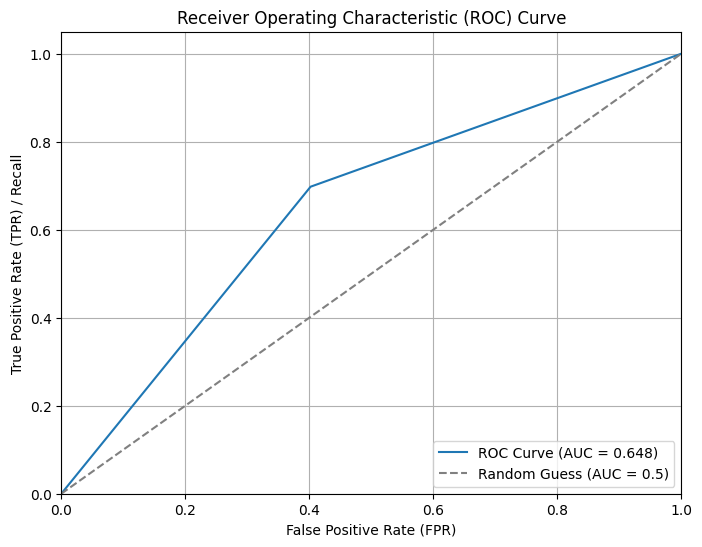

In [33]:
# 1. Calculate FPR and TPR for all thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# 2. Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
# Plot the random guess line (AUC = 0.5)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess (AUC = 0.5)')

# 3. Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [34]:
# Let's run some diagnostics
# 1. Check tree depth
print(f"Tree depth: {clf.get_depth()}")
print(f"Number of leaves: {clf.get_n_leaves()}")

# 2. Top 10 features by importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 features:")
print(importance_df.head(10))

# 3. Check for remaining NaNs
print(f"\nRemaining NaN values: {X_train.isnull().sum().sum()}")

# 4. How many features total?
print(f"\nTotal features in model: {X_train.shape[1]}")

Tree depth: 8
Number of leaves: 241

Top 10 features:
            feature  importance
4             grade    0.586197
5         sub_grade    0.209586
1              term    0.054575
11              dti    0.035552
22      tot_cur_bal    0.032047
9    home_ownership    0.018123
2          int_rate    0.015143
3       installment    0.012706
7        annual_inc    0.011533
13  fico_range_high    0.008805

Remaining NaN values: 0

Total features in model: 24


##### MODEL B: Without Grade and Sub-Grade

In [35]:
feature_cols = [col for col in df_model.columns 
                if col not in ['loan_status', 'default_flag', 'funded_amnt', 'grade', 'sub_grade']]

X = df_model[feature_cols]
y = df_model['default_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Constrained tree this time
clf = DecisionTreeClassifier(
    max_depth=8,
    min_samples_split=500,
    min_samples_leaf=200,
    class_weight='balanced', #start with balanced class weights to handle imbalance in target variable
    random_state=42
)  # start with balanced class weights to handle imbalance in target variable
clf.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",8
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",500
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",200
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the curren

Accuracy: 0.6262740152807655
              precision    recall  f1-score   support

           0       0.88      0.61      0.72    431236
           1       0.30      0.68      0.42    108004

    accuracy                           0.63    539240
   macro avg       0.59      0.64      0.57    539240
weighted avg       0.77      0.63      0.66    539240

ROC AUC Score: 0.645


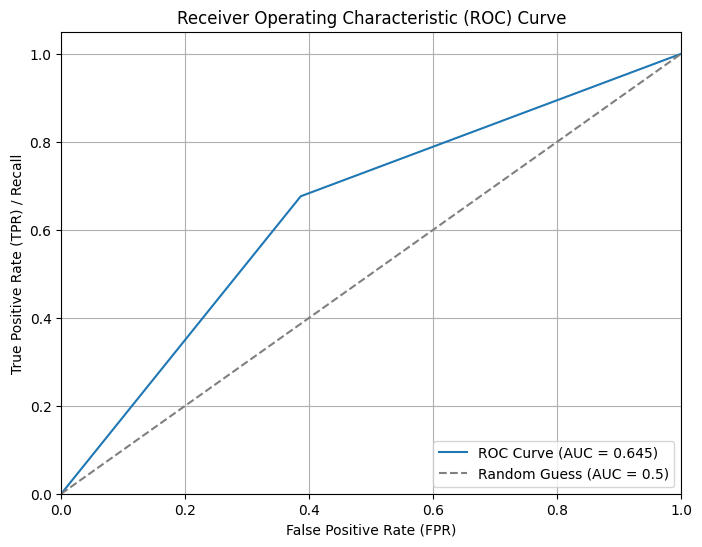

In [36]:
# Predict on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report
print(classification_report(y_test, y_pred))

auc_score = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {auc_score:.3f}")

# 1. Calculate FPR and TPR for all thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# 2. Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
# Plot the random guess line (AUC = 0.5)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess (AUC = 0.5)')

# 3. Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [37]:
# Let's run some diagnostics
# 1. Check tree depth
print(f"Tree depth: {clf.get_depth()}")
print(f"Number of leaves: {clf.get_n_leaves()}")

# 2. Top 10 features by importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 features:")
print(importance_df.head(10))

# 3. Check for remaining NaNs
print(f"\nRemaining NaN values: {X_train.isnull().sum().sum()}")

# 4. How many features total?
print(f"\nTotal features in model: {X_train.shape[1]}")

Tree depth: 8
Number of leaves: 241

Top 10 features:
                feature  importance
2              int_rate    0.782398
1                  term    0.061149
9                   dti    0.038548
7        home_ownership    0.032961
20          tot_cur_bal    0.024836
10       fico_range_low    0.013031
3           installment    0.011986
11      fico_range_high    0.011188
5            annual_inc    0.008757
8   verification_status    0.005473

Remaining NaN values: 0

Total features in model: 22


##### MODEL C: Without Grade, Sub-Grade and Int_Rate

In [38]:
feature_cols = [col for col in df_model.columns 
                if col not in ['loan_status', 'default_flag', 'funded_amnt', 'grade', 'sub_grade', 'int_rate']]

X = df_model[feature_cols]
y = df_model['default_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Constrained tree this time
clf = DecisionTreeClassifier(
    max_depth=8,
    min_samples_split=500,
    min_samples_leaf=200,
    class_weight='balanced', #start with balanced class weights to handle imbalance in target variable
    random_state=42
)  # start with balanced class weights to handle imbalance in target variable
clf.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",8
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",500
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",200
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the curren

Accuracy: 0.6241784734070173
              precision    recall  f1-score   support

           0       0.87      0.62      0.73    431236
           1       0.30      0.63      0.40    108004

    accuracy                           0.62    539240
   macro avg       0.58      0.63      0.56    539240
weighted avg       0.76      0.62      0.66    539240

ROC AUC Score: 0.628


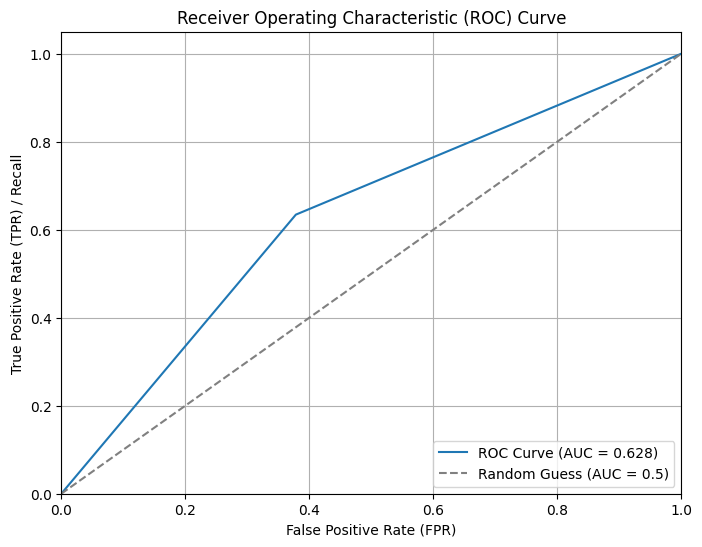

In [39]:
# Predict on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report
print(classification_report(y_test, y_pred))

auc_score = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {auc_score:.3f}")

# 1. Calculate FPR and TPR for all thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# 2. Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
# Plot the random guess line (AUC = 0.5)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess (AUC = 0.5)')

# 3. Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [40]:
# Let's run some diagnostics
# 1. Check tree depth
print(f"Tree depth: {clf.get_depth()}")
print(f"Number of leaves: {clf.get_n_leaves()}")

# 2. Top 10 features by importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 features:")
print(importance_df.head(20))

# 3. Check for remaining NaNs
print(f"\nRemaining NaN values: {X_train.isnull().sum().sum()}")

# 4. How many features total?
print(f"\nTotal features in model: {X_train.shape[1]}")

Tree depth: 8
Number of leaves: 237

Top 10 features:
                feature  importance
1                  term    0.391928
9        fico_range_low    0.190296
8                   dti    0.095683
10      fico_range_high    0.065433
19          tot_cur_bal    0.050200
4            annual_inc    0.045583
6        home_ownership    0.041891
2           installment    0.040992
12       inq_last_6mths    0.032626
7   verification_status    0.022707
15            revol_bal    0.008200
3               purpose    0.005242
20     total_rev_hi_lim    0.003325
17            total_acc    0.002457
5            emp_length    0.001698
16           revol_util    0.000784
13             open_acc    0.000661
0             loan_amnt    0.000294
14              pub_rec    0.000000
11          delinq_2yrs    0.000000

Remaining NaN values: 0

Total features in model: 21


In [41]:
# Need to output the final dataframe for use in the next notebook
df_model.to_csv("../data/processed_loan_data.csv", index=False)

Going with MODEL C...

=> MODEL C RATIONALE:
- Removes Lending Club derived variables (grade, sub_grade, int_rate)
- Uses only raw financial characteristics available at application time
- More realistic for real-world underwriting tool
- AUC: 0.628 baseline → Target: 0.75 after feature engineering + tuning
- Top drivers: term, FICO, DTI, annual income, home ownership

Application Build Context:

- Baseline (Model C):     AUC = 0.628  ← Where we are
- After Feature Eng:      AUC = 0.65+  ← Next step
- After Hyperparameter:   AUC = 0.70+  ← Then this
- Target:                 AUC = 0.75   ← The goal
- Remaining gap (25%):    Human judgment + Claude API context